In [1]:
import time
import pickle
import pandas as pd
import numpy as np
from scipy.stats import uniform
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns
import mglearn

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import KBinsDiscretizer, OneHotEncoder, PolynomialFeatures, StandardScaler, MinMaxScaler, RobustScaler 
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV

from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR

# Import helperfunctions
from ML_functions import fun_load_data, fun_preprocessing, fun_fit_tuning
from ML_functions import fun_convert_time
from ML_functions import fun_tuning_results, fun_scores
from ML_functions import plot_feature_weights

# Start time count
start_script = time.time()

# Load optimization_problem ('TSP' or 'CVRP') and the size of the train set
with open('settings.pkl', 'rb') as file:
    settings = pickle.load(file)
optimization_problem, train_size = settings['optimization_problem'], settings['train_size']

# Assign string 'TSP' or 'CVRP' to the following variable to define the optimization problem
optimization_problem = 'TSP'
train_size = 0.75

# Load data
data = fun_load_data(optimization_problem=optimization_problem)
X, y, train_data = fun_preprocessing(data)

# Create a train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_size, random_state=0)

# Save train size and create a dictionary to store the results
train_size = f'{int(np.round(100 * len(X_train)/len(X)))} %'
results_dict = {}

# **A. Instance-based models**
### **1. K-nearest Neighbor - KNN**

In [2]:
# Grid search cross validation with data scaling
pipe = Pipeline(steps=[('scaler', None), 
                       ('knn', KNeighborsRegressor(n_jobs=-1))])

param_grid = {'scaler': [StandardScaler(), MinMaxScaler()],
              'knn__n_neighbors': list(np.arange(start=5, stop=12))}

grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=3,
                           scoring='neg_mean_absolute_percentage_error', verbose=False, n_jobs=-1)
fit_time = fun_fit_tuning(search_method=grid_search, X_train=X_train, y_train=y_train, file_name=optimization_problem + '_KNN')

# View results of grid search cross validation
model_results_dict = fun_scores(model=grid_search, X_train=X_train, y_train=y_train, cv=2)
model_results_dict['CV computation time'] = fit_time

# Save results to dictionary
results_dict['KNN'] = model_results_dict

# View grid search CV scores of all parameter combinations
results_df = fun_tuning_results(search_method=grid_search, search_space=param_grid)

CV MAPE train data:  32.4886 %
CV RMSE train data:  5.6209

Best model / parameter combination:


{'knn__n_neighbors': 7, 'scaler': StandardScaler()}

Cross validation scores of different parameter combinations:


,param_scaler,param_knn__n_neighbors,mean_test_score,converted_mean_fit_time
0,StandardScaler(),7,-0.324886,0s
1,StandardScaler(),5,-0.326632,0s
2,StandardScaler(),8,-0.326680,0s
3,StandardScaler(),6,-0.327466,0s
4,StandardScaler(),9,-0.329034,0s
5,StandardScaler(),10,-0.330512,0s
6,StandardScaler(),11,-0.331758,0s
7,MinMaxScaler(),6,-0.368895,0s
8,MinMaxScaler(),5,-0.369683,0s
9,MinMaxScaler(),7,-0.372847,0s


# **B. Linear Models**
### **1. Linear Regression**

CV MAPE train data:  15.5611 %
CV RMSE train data:  3.2103
CV computation time: 0s


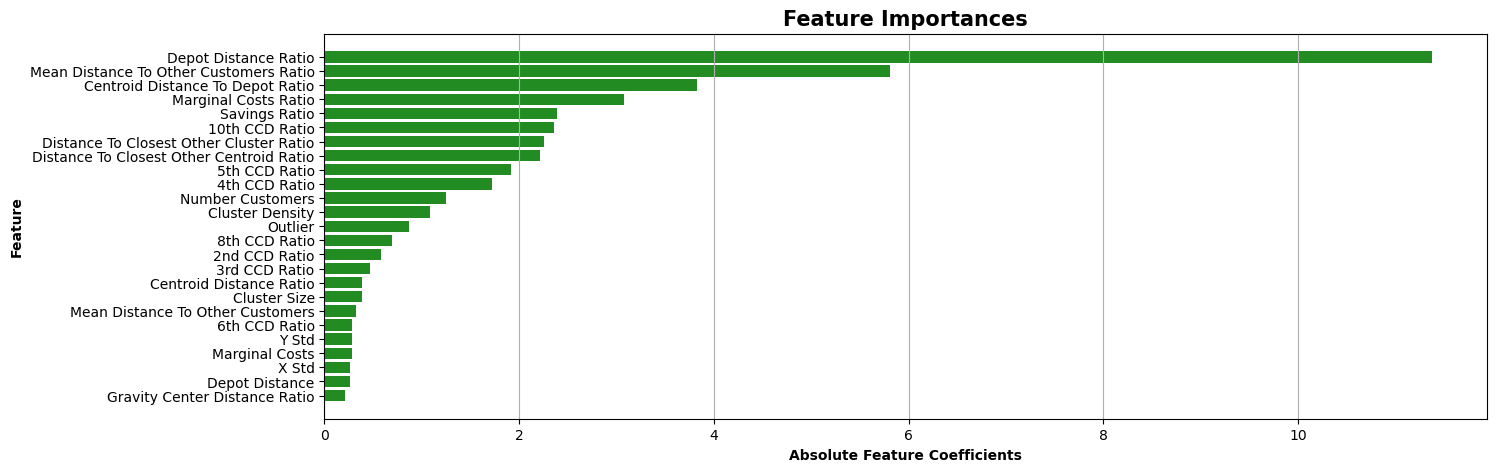

In [3]:
# Create model
lr = LinearRegression()

# Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
model_results_dict = fun_scores(model=lr, X_train=X_train, y_train=y_train, cv=10)

# Save results to dictionary
results_dict['Linear Regression'] = model_results_dict # No parameters -> no grid search only CV

# Fit model on train set (default parameters) and show top 25 absolute feature weights
plot_feature_weights(model=lr.fit(X_train, y_train), X_train=X_train, n_features=25)

**Apply binning (one hot encoding) for most important continuous features**

In [4]:
# Load most important features from script 'feature_selection.ipynb'
top_features = list(pd.read_csv('02_best_features/' + optimization_problem + '_top_features'))

# Example with only two bins per feature
discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')
binned_features = discretizer.fit_transform(X_train[top_features])
binned_df = pd.DataFrame(binned_features, columns=[f'{col} binned' for col in top_features])
display(X_train[top_features].head(5))
display(binned_df.head(5))

,Depot Distance Ratio,Marginal Costs,Savings,Depot Distance,Marginal Costs Ratio,Mean Distance To Other Customers Ratio,Mean Distance To Other Customers,Gravity Center Distance Ratio,Gravity Center Distance,Total Costs,4th CCD,3rd CCD,5th CCD,2nd CCD,Centroid Distance To Depot,Closest Customer Distance (CCD),4th CCD Ratio,Savings Ratio
89174,1.728754,9.400484,9.400484,64.281866,1.094947,1.363292,72.431314,1.671816,61.947673,339.397032,70.410422,49.525021,72.499974,35.010960,63.098136,13.341860,1.786414,1.175052
46832,1.359148,54.587657,54.587657,80.194371,7.963812,1.323928,80.103982,1.528793,64.533742,329.160458,71.149579,61.002661,82.000671,58.175261,80.194371,50.627308,1.437703,7.963812
42659,1.193736,0.238708,0.238708,50.309378,0.009806,0.853870,46.297486,0.745827,26.546176,381.470799,36.262463,33.798749,39.639909,29.162556,18.464263,14.677402,0.785937,0.011586
60502,1.236261,13.413566,11.160753,58.681687,1.084504,1.093556,72.967298,1.210069,57.236098,401.076659,57.224995,52.076613,63.789804,40.684972,55.409718,17.026269,1.086771,1.222365
42890,0.721345,4.965204,4.965204,45.388932,0.437842,0.866398,47.615071,0.768528,28.790741,339.769741,42.877564,28.921563,44.914824,21.950783,40.048576,15.590889,0.935603,0.486498


,Depot Distance Ratio binned,Marginal Costs binned,Savings binned,Depot Distance binned,Marginal Costs Ratio binned,Mean Distance To Other Customers Ratio binned,Mean Distance To Other Customers binned,Gravity Center Distance Ratio binned,Gravity Center Distance binned,Total Costs binned,4th CCD binned,3rd CCD binned,5th CCD binned,2nd CCD binned,Centroid Distance To Depot binned,Closest Customer Distance (CCD) binned,4th CCD Ratio binned,Savings Ratio binned
0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# Binning the continuous features to create a data frame with the bin affiliation for each feature (value between 0 and 29)
discretizer = KBinsDiscretizer(n_bins=30, encode='ordinal', strategy='uniform')
binned_features = discretizer.fit_transform(X_train[top_features])
binned_df = pd.DataFrame(binned_features, columns=[f'{col} binned' for col in top_features])

# One-Hot Encoding the binned features
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(binned_df)
one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=encoder.get_feature_names_out(binned_df.columns))

# Combine with original data
X_train_onehot = pd.concat([X_train.reset_index(drop=True), one_hot_encoded_df], axis=1)
display(X_train_onehot.head())

# Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
model_results_dict = fun_scores(model=LinearRegression(), X_train=X_train_onehot, y_train=y_train, cv=10)

# Save results to dictionary
results_dict['Linear Regression One hot'] = model_results_dict

,Instance ID,Number Customers,X,Y,X Depot,Y Depot,Depot Distance,Closest Customer Distance (CCD),2nd CCD,3rd CCD,...,Savings Ratio binned_18.0,Savings Ratio binned_19.0,Savings Ratio binned_20.0,Savings Ratio binned_21.0,Savings Ratio binned_22.0,Savings Ratio binned_23.0,Savings Ratio binned_24.0,Savings Ratio binned_25.0,Savings Ratio binned_26.0,Savings Ratio binned_29.0
0,8942,14,88.231619,89.283158,54.344296,34.658919,64.281866,13.341860,35.010960,49.525021,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5622,11,92.274327,14.845403,12.101095,16.686579,80.194371,50.627308,58.175261,61.002661,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,5242,11,76.682972,40.637998,28.161031,53.929155,50.309378,14.677402,29.162556,33.798749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6792,12,99.609501,93.412637,59.669228,50.420603,58.681687,17.026269,40.684972,52.076613,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5263,11,48.204759,80.900408,4.033165,91.341928,45.388932,15.590889,21.950783,28.921563,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


CV MAPE train data:  14.7894 %
CV RMSE train data:  3.5532
CV computation time: 1s


**Add logarithm for most important continuous features**

In [6]:
# Compute log for the continuous features from above
log_df = np.log(X_train[top_features] + 1)
log_df.columns = [f'{i} log' for i in top_features]

# Add log features to the one hot encoded X_train data frame
X_train_onehot_log = pd.concat([X_train_onehot, log_df.reset_index(drop=True)], axis=1)
display(X_train_onehot_log.head())

# Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
model_results_dict = fun_scores(model=LinearRegression(), X_train=X_train_onehot_log, y_train=y_train, cv=10)

,Instance ID,Number Customers,X,Y,X Depot,Y Depot,Depot Distance,Closest Customer Distance (CCD),2nd CCD,3rd CCD,...,Gravity Center Distance log,Total Costs log,4th CCD log,3rd CCD log,5th CCD log,2nd CCD log,Centroid Distance To Depot log,Closest Customer Distance (CCD) log,4th CCD Ratio log,Savings Ratio log
0,8942,14,88.231619,89.283158,54.344296,34.658919,64.281866,13.341860,35.010960,49.525021,...,4.142304,5.830113,4.268444,3.922469,4.297285,3.583823,4.160415,2.663183,1.024755,0.777052
1,5622,11,92.274327,14.845403,12.101095,16.686579,80.194371,50.627308,58.175261,61.002661,...,4.182565,5.799579,4.278741,4.127177,4.418849,4.080504,4.396846,3.944051,0.891056,2.193196
2,5242,11,76.682972,40.637998,28.161031,53.929155,50.309378,14.677402,29.162556,33.798749,...,3.315864,5.946652,3.617986,3.549581,3.704751,3.406601,2.968580,2.752220,0.579943,0.011519
3,6792,12,99.609501,93.412637,59.669228,50.420603,58.681687,17.026269,40.684972,52.076613,...,4.064505,5.996643,4.064315,3.971736,4.171148,3.730141,4.032641,2.891830,0.735618,0.798572
4,5263,11,48.204759,80.900408,4.033165,91.341928,45.388932,15.590889,21.950783,28.921563,...,3.394198,5.831207,3.781403,3.398579,3.826788,3.133352,3.714756,2.808854,0.660419,0.396423


CV MAPE train data:  14.4067 %
CV RMSE train data:  3.3898
CV computation time: 1s


**Interactions and Polynomials**

In [7]:
# Generate interaction and polynomial features with all polynomial combinations of the features up to the specified degree (for all continuous features from above)
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
poly.fit(X_train[top_features])
poly_df = pd.DataFrame(poly.transform(X_train[top_features]))

# Add polynomial features to the X_train data frame
X_train_poly = pd.concat([X_train_onehot[[i for i in X_train_onehot.columns if i not in top_features]].reset_index(drop=True), poly_df], axis=1)
X_train_poly.columns = X_train_poly.columns.astype(str)
display(X_train_poly.head())

# Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
model_results_dict = fun_scores(model=LinearRegression(), X_train=X_train_poly, y_train=y_train, cv=10)

# Save results to dictionary
results_dict['Linear Regression Polynomial'] = model_results_dict

,Instance ID,Number Customers,X,Y,X Depot,Y Depot,6th CCD,7th CCD,8th CCD,9th CCD,...,1319,1320,1321,1322,1323,1324,1325,1326,1327,1328
0,8942,14,88.231619,89.283158,54.344296,34.658919,72.690372,72.928122,81.200933,82.240356,...,2374.920966,317.991056,209.165357,42.577548,28.006285,18.421727,5.700939,3.749913,2.466585,1.622449
1,5622,11,92.274327,14.845403,12.101095,16.686579,85.239472,87.923555,91.166478,106.308268,...,129764.084968,3685.011518,20412.240353,104.646134,579.662245,3210.900430,2.971718,16.461119,91.182434,505.083293
2,5242,11,76.682972,40.637998,28.161031,53.929155,45.693274,48.048213,57.377593,77.614159,...,3161.895617,169.311459,2.495916,9.066197,0.133650,0.001970,0.485472,0.007157,0.000105,0.000002
3,6792,12,99.609501,93.412637,59.669228,50.420603,71.054448,77.417310,88.912269,97.159295,...,4935.810067,315.048202,354.356116,20.109236,22.618224,25.440253,1.283554,1.443700,1.623828,1.826430
4,5263,11,48.204759,80.900408,4.033165,91.341928,50.946389,55.882960,60.607076,69.585351,...,3789.768351,227.422435,118.255934,13.647526,7.096490,3.690058,0.818982,0.425857,0.221439,0.115145


CV MAPE train data:  6.9915 %
CV RMSE train data:  3.1509
CV computation time: 26s


**Plot Shapley Values and model predictions**

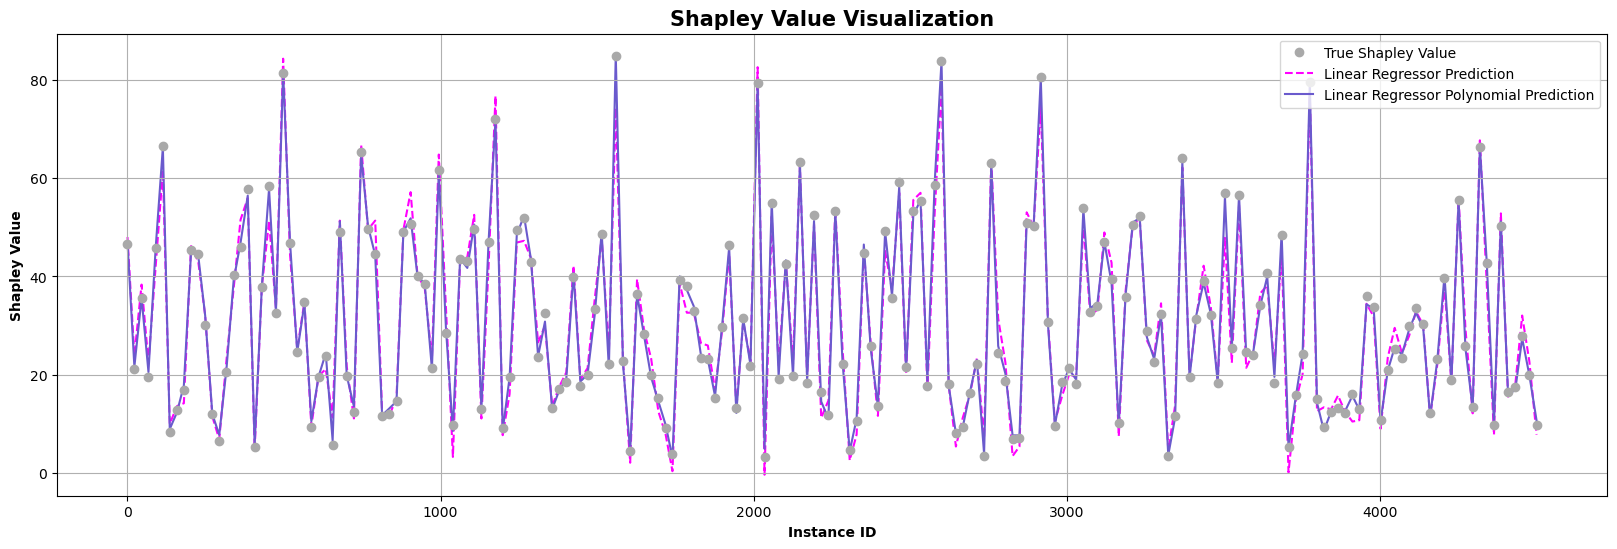

In [19]:
# Create model
lr = LinearRegression()

# Fit model on original train set and make a prediction
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_train)

# Fit model on one hot encoded and polynomial train set and make a prediction
lr.fit(X_train_poly, y_train)
lr_poly_pred = lr.predict(X_train_poly)

# Select 200 instance IDs
line = np.linspace(0, len(X_train)-1, 200).astype('int')

# Create a plot with 200 True Shapley Values and the predictions from above
plt.figure(figsize=(20, 6))
plt.plot(line, [list(y_train)[i] for i in line], 'o', c='darkgrey', label='True Shapley Value', zorder=2)
plt.plot(line, [list(lr_pred)[i] for i in line], '--', c='magenta', label='Linear Regressor Prediction', zorder=0)
plt.plot(line, [list(lr_poly_pred)[i] for i in line], '-', c='slateblue', label='Linear Regressor Polynomial Prediction', zorder=1)
plt.xlabel('Instance ID', size=10, fontweight='bold')
plt.ylabel('Shapley Value', size=10, fontweight='bold')
plt.title('Shapley Value Visualization', size=15, fontweight='bold')
plt.legend(loc='upper right')
plt.grid()
plt.show()

### **2. Rigde Regression (L2-Regularization)**

In [20]:
# Define the preprocessing steps for continuous features
onehot_transformer = Pipeline(steps=[('binning', KBinsDiscretizer(n_bins=30, encode='ordinal', strategy='uniform')),
                                     ('onehot', OneHotEncoder(sparse_output=False, handle_unknown='ignore'))])

poly_transformer = Pipeline(steps=[('poly', PolynomialFeatures(degree=3, interaction_only=False, include_bias=False))])

# Combine preprocessing steps using ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('onehot', onehot_transformer, top_features),
                                               ('poly', poly_transformer, top_features)],
                                               remainder='passthrough')

# Define the model pipeline
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('ridge', Ridge(solver='svd'))])

# Grid search cross validation
param_grid = {'ridge__alpha': [0.1, 1, 10]} # Higher alpha means higher regularization and lower model complexity (less overfitting)}

grid_search = GridSearchCV(estimator=pipe, param_grid=param_grid, cv=2,
                           scoring='neg_mean_absolute_percentage_error', 
                           verbose=False, n_jobs=-1)
fit_time = fun_fit_tuning(search_method=grid_search, X_train=X_train, y_train=y_train, file_name=optimization_problem + '_Ridge')

# View results of grid search cross validation
model_results_dict = fun_scores(model=grid_search, X_train=X_train, y_train=y_train, cv=3)
model_results_dict['CV computation time'] = fit_time

# Save results to dictionary
results_dict['Ridge Regression'] = model_results_dict

# View grid search CV scores of all parameter combinations
results_df = fun_tuning_results(search_method=grid_search, search_space=param_grid)

CV MAPE train data:  7.3729000000000005 %
CV RMSE train data:  0.7988

Best model / parameter combination:


{'ridge__alpha': 10}

Cross validation scores of different parameter combinations:


,param_ridge__alpha,mean_test_score,converted_mean_fit_time
0,10,-0.073729,19s
1,1,-0.082465,19s
2,0.1,-0.094725,19s


### **3. Lasso Regression (L1-Regularization)**

In [ ]:
if (optimization_problem == 'TSP') and False: # If False: don't train Lasso

    # Grid search cross validation with original dataset
    param_grid = {'alpha': [0.1, 1, 10]} # Higher alpha means higher regularization and lower model complexity (less overfitting)

    grid_search = GridSearchCV(estimator=Lasso(max_iter=1000), param_grid=param_grid, cv=2,
                               scoring='neg_mean_absolute_percentage_error', 
                               verbose=False, n_jobs=-1)
    fit_time = fun_fit_tuning(search_method=grid_search, X_train=X_train, y_train=y_train, file_name=optimization_problem + '_Lasso')

    # View results of grid search cross validation
    model_results_dict = fun_scores(model=grid_search, X_train=X_train, y_train=y_train, cv=2)

    # Polynomial dataset and default parameter alpha (CV too computational expensive)
    # Estimate model performance with cross validation on the train set (scoring: MAPE and RMSE)
    model_results_dict = fun_scores(model=Lasso(alpha=1), X_train=X_train_poly, y_train=y_train, cv=2)

    # Save results to dictionary
    results_dict['Lasso Regression'] = model_results_dict # No grid search only cv

else: print('This cell is only executed for the TSP!')

CV MAPE train data:  16.4015 %
CV RMSE train data:  3.314

Best model / parameter combination:


c:\Users\dennis\anaconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.066e+05, tolerance: 2.363e+03
  model = cd_fast.enet_coordinate_descent(


{'alpha': 0.1}

CV MAPE train data:  6.293500000000001 %
CV RMSE train data:  1.4059
CV computation time: 1m, 4s


# **C. Compare Results**

In [ ]:
display(pd.DataFrame(results_dict).sort_values(by='MAPE', axis=1))
print('Total script computation time:', fun_convert_time(start=start_script, end=time.time()))

,Linear Regression Polynomial,Ridge Regression,Lasso Regression,Linear Regression One hot,Linear Regression,KNN
MAPE,4.7638,4.7824,6.2935,14.5161,16.1477,25.2382
RMSE,1.0494,0.9923,1.4059,2.8703,3.218,4.412
CV computation time,"2m, 20s","2m, 0s","1m, 4s",20s,1s,"1m, 50s"


Total script computation time: 19m, 27s


In [ ]:
# Get model names, the scores for each model and the computation times
model_names = results_dict.keys()
cv_times = [value['CV computation time'] for value in results_dict.values()]
MAPE_train_scores = [value['MAPE'] for value in results_dict.values()]
RMSE_train_scores = [value['RMSE'] for value in results_dict.values()]

# Show scores per instance size for each model
cv_times_df = pd.DataFrame(data=[cv_times], columns=model_names, index=['CV Computation Times'])
MAPE_df = pd.DataFrame(data=[MAPE_train_scores], columns=model_names, index=['MAPE Scores']).sort_values(by='MAPE Scores', axis=1)
RMSE_df = pd.DataFrame(data=[RMSE_train_scores], columns=model_names, index=['RMSE Scores']).sort_values(by='RMSE Scores', axis=1)
display(cv_times_df, MAPE_df, RMSE_df, )

# Print total script run time
print('Total script computation time:', fun_convert_time(start=start_script, end=time.time()))

,KNN,Linear Regression,Linear Regression One hot,Linear Regression Polynomial,Ridge Regression,Lasso Regression
CV Computation Times,"1m, 50s",1s,20s,"2m, 20s","2m, 0s","1m, 4s"


,Linear Regression Polynomial,Ridge Regression,Lasso Regression,Linear Regression One hot,Linear Regression,KNN
MAPE Scores,4.7638,4.7824,6.2935,14.5161,16.1477,25.2382


,Ridge Regression,Linear Regression Polynomial,Lasso Regression,Linear Regression One hot,Linear Regression,KNN
RMSE Scores,0.9923,1.0494,1.4059,2.8703,3.218,4.412


Total script computation time: 19m, 27s
